# Description

#### O Desafio

Você faz parte do time de cientistas de dados da empres All In One Place, que precisa determinar quem são os clientes elegíveis para participar do Insiders. Em posse dessa lista, o time de Marketing fará uma sequência de ações personalizadas e exclusivas ao grupo, de modo a aumentar o faturamento e a frequência de compra.
Como resultado para esse projeto, é esperado que você entregue um lista de pessoas elegíveis a participar do programa Insiders, junto com um relatório respondendo às seguintes perguntas:

1. Quem são as pessoas elegíveis para participar do programa de Insiders?
2. Quantos clinetes farão parte do grupo?
3. Quais as principais características desses clientes?
4. Qual a porcentagem de contribuição do faturamento, vinda do Insiders?
5. Qual a expectativa de faturamento desse grupo para os próximos meses?
6. Quais as condições para uma pessoa ser elegível ao Insiders?
7. Quais as condições para uma pessoa ser removida do Insiders?
8. Qual a garantia que o programa Insiders é melhor que o restante da base?
9. Quais ações o time de marketing pode realizar para aumentar o faturamento?

#### Os dados

- Invoice Number: Identificador único de cada transação.
- Stock Code Product: Código do item
- Description Product: nome do item
- Quantity: A quantidade de item comprado por transação.
- Invoice Date: O dia em que a transação ocorreu.
- Unit Price: Preço do produto por unidade.
- Customer ID: Identificador único do cliente
- Country: O nome do pais que o cliente reside.

# Solution Planning

1. Quem são as pessoas elegíveis para participar do programa de Insiders?
    - Monetário
        - valor médio dos pedidos
        - LTV
        - valor total dos pedidos
    - Recencia
        - Quantas vezes o cliente comprou
    - Frequencia
        - Frequencia de compra
        
        
2. Quantos clinetes farão parte do grupo?
    - Total de clientes + percentual sobre a base.
    
    
3. Quais as principais características desses clientes?
    - Lista das principais caracteristicas de compra.


4. Qual a porcentagem de contribuição do faturamento, vinda do Insiders?
    - Percentual de faturamento do grupo sobre o total de vendas.


5. Qual a expectativa de faturamento desse grupo para os próximos meses?
    - Previsão de faturamento.

6. Quais as condições para uma pessoa ser elegível ao Insiders?
7. Quais as condições para uma pessoa ser removida do Insiders?
8. Qual a garantia que o programa Insiders é melhor que o restante da base?
    - Teste A\B
    - Teste A\B gausiano
    - 


9. Quais ações o time de marketing pode realizar para aumentar o faturamento?


#### Benchmark

- RFM
    - https://www.optimove.com/resources/learning-center/customer-segmentation-via-cluster-analysis
    - https://www.techtarget.com/searchdatamanagement/definition/RFM-analysis?
    - https://www.omniconvert.com/blog/rfm-score/ - segments
- K-Means
    - https://towardsdatascience.com/customer-segmentation-using-k-means-clustering-d33964f238c3
    - Elbow Method Visualizer
    
    
        from yekkiwbrick.cluster import KElbowVisualiser
        Elbow_M = KElbowVisualizer(KMeans(), k=10)
        Elbow_M.fit(PCA_ds)
        Elbow_M.show()

#### Ideias de entrega
- Começar aplicando RFM para gerar valor e trazer as principais caracteristicas dos clientes.
- Relatório de Insights
- Algoritmo K-means (usar RFM para entrada)
- Relatório Final

#### Ideias para outros algoritmos
- Ativação de recompra
    - Identificar o momento certo de mandar propagandas e promoções para o cliente 'lembrar' de comprar na loja.
- Previsão de classificação
    - Prever em qual classificação o cliente vai se encaixar. Com isso podemos direcionar o marketing para que ele possa subir no nosso rank de clientes.

# 0. Imports & Help Functions

## 0.1 Imports

In [94]:
import inflection
import re

import pandas     as pd
import numpy      as np
import seaborn    as sns
import umap.umap_ as umap

from matplotlib import pyplot  as plt
from sklearn    import metrics as mt

from sklearn.preprocessing import LabelEncoder
from sklearn.cluster       import KMeans
from sklearn.ensemble      import RandomForestClassifier
from yellowbrick.cluster   import KElbowVisualizer, SilhouetteVisualizer
from IPython.display       import HTML

## 0.2 Data Import

In [2]:
df_raw = pd.read_csv('dataset/ecommerce.csv', encoding='windows-1252')
df_raw = df_raw.drop(columns='Unnamed: 8')

## 0.3 Help Functions

In [99]:
# Função para extração do número no stock_code
def extraction(x):
    match = re.search('\d+', x)
    if match:
        return match.group(0)
    else:
        return None
    
# Função para análise exploratória

def exploratori(df4):
    sns.set(rc={'figure.figsize':(15,5)})

    for coluna in df4.columns:
        plt.figure()

        if pd.api.types.is_numeric_dtype(df4[coluna]):
            # Feature name
            html_content = "<h1>" + coluna.upper() + "</h1>"
            display(HTML(html_content))        

            # Plots
            plt.subplot(1, 2, 1)
            sns.boxplot(y=df4[coluna])
            plt.title(f"Boxplot da coluna '{coluna}'")

            plt.subplot(1, 2, 2)
            sns.histplot(data=df4[coluna], kde=True)
            plt.title(f"Histograma da coluna '{coluna}'")

            # Statistcs
            aux1 = pd.DataFrame(data={'feature':[coluna]}, index=['statistcs'])
            aux1['average'] = df4[coluna].mean()
            aux1['min'] = df4[coluna].min()
            aux1['median'] = df4[coluna].median()
            aux1['max'] = df4[coluna].max()
            aux1['std_deviation'] = df4[coluna].std()

            plt.show()
            display(HTML(aux1.to_html()))

    # Pair Plot
    display(HTML("<h1>Pair Plot</h1>"))   
    sns.pairplot(df4)

# 1. Data Description

In [4]:
df1 = df_raw.copy()

In [5]:
df1.head()

InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

  InvoiceDate  UnitPrice  CustomerID         Country  
0   29-Nov-16       2.55     17850.0  United Kingdom  
1   29-Nov-16       3.39     17850.0  United Kingdom  
2   29-Nov-16       2.75     17850.0  United Kingdom  
3   29-Nov-16       3.39     17850.0  United Kingdom  
4   29-Nov-16       3.39     17850.0  United Kingdom

## 1.1 Rename Columns

In [6]:
old_columns = df1.columns
snekecase = lambda x: inflection.underscore(x)
new_columns = list(map(snekecase, old_columns))
df1.columns = new_columns

df1.head()

invoice_no stock_code                          description  quantity  \
0     536365     85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1     536365      71053                  WHITE METAL LANTERN         6   
2     536365     84406B       CREAM CUPID HEARTS COAT HANGER         8   
3     536365     84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4     536365     84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

  invoice_date  unit_price  customer_id         country  
0    29-Nov-16        2.55      17850.0  United Kingdom  
1    29-Nov-16        3.39      17850.0  United Kingdom  
2    29-Nov-16        2.75      17850.0  United Kingdom  
3    29-Nov-16        3.39      17850.0  United Kingdom  
4    29-Nov-16        3.39      17850.0  United Kingdom

## 1.2 Data Dimensions

In [7]:
# print("Linhas: {}".format(df1.shape[0]))
# print("Colunas: {}".format(df1.shape[1]))

## 1.3 Data Dtypes

In [8]:
# df1.dtypes

## 1.4 Check NA

In [9]:
df1.isna().sum()

invoice_no           0
stock_code           0
description       1454
quantity             0
invoice_date         0
unit_price           0
customer_id     135080
country              0
dtype: int64

## 1.5 Conclusions About the Data

No momento do treino do modelo eu não vou precisar dos dados de descrição do produto (description), por que o número de armazenagem (stock_code) já me passa a ideia de qual produto se trata.

Preciso fazer o drop das linhas que não tem dados no customer_id por precisar agrupar meus clientes e sem esse dado eu não sei quem comprou o produto x ou y.

## 1.6 FillOut NA

### 1.6.1 'Customer_id'

In [10]:
# Para esse ciclo eu vou manter todos os dados e para isso vou criar os 'client_id' faltantes. 
# Vou utilizar um padrão diferente, de 6 números para fazer o preenchimento e saber quais os dados criados.

aux1 = df1[df1['customer_id'].isna()][['invoice_no', 'customer_id']].drop_duplicates(subset='invoice_no').reset_index(drop=True)

for i in range(len(aux1)):
    aux1.loc[i, 'customer_id'] = 100000 + i

df1 = df1.merge(aux1, on='invoice_no', how='left')

df1['customer_id'] = df1['customer_id_x'].combine_first(df1['customer_id_y'])
df1.drop(columns=['customer_id_x', 'customer_id_y'], inplace=True)

### 1.6.2 'description'

In [11]:
# Como eu tenho o stock_code, não vou precisar da descrição do item no treinamento. Dessa forma, vou manter esses dados
# com NaN

## 1.7 Charge Dtypes

In [12]:
df1['invoice_date'] = pd.to_datetime(df1['invoice_date'])

## 1.8 Descriptive Statistical

In [13]:
df_num = df1.select_dtypes(include=['int64', 'float64'])
df_cat = df1.select_dtypes(exclude=['int64', 'float64', 'datetime64[ns]'])

### 1.8.1 Numerical Attributes

In [14]:
d1 = pd.DataFrame (df_num.min()).T
d2 = pd.DataFrame (df_num.max()).T
d3 = pd.DataFrame (df_num.max() - df_num.min()).T
d4 = pd.DataFrame (df_num.mean()).T
d5 = pd.DataFrame (df_num.median()).T
d6 = pd.DataFrame (df_num.std()).T
d7 = pd.DataFrame (df_num.skew()).T
d8 = pd.DataFrame (df_num.kurt()).T

df_num = pd.concat([d1, d2, d3, d4, d5, d6, d7, d8]).T.reset_index()
df_num.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'standard_deviation', 'skewness', 'kurtosis']

df_num


attributes       min       max      range          mean    median  \
0     quantity -80995.00   80995.0  161990.00      9.552250      3.00   
1   unit_price -11062.06   38970.0   50032.06      4.611114      2.08   
2  customer_id  12346.00  103709.0   91363.00  36879.462864  16249.00   

   standard_deviation    skewness       kurtosis  
0          218.081158   -0.264076  119769.160031  
1           96.759853  186.506972   59005.719097  
2        37505.522029    1.154680      -0.657017

In [15]:
df_num.describe().T

count           mean           std           min  \
min                   3.0  -26570.353333  48564.554377 -80995.000000   
max                   3.0   74558.000000  32846.015847  38970.000000   
range                 3.0  101128.353333  56614.191477  50032.060000   
mean                  3.0   12297.875409  21288.279345      4.611114   
median                3.0    5418.026667   9379.898066      2.080000   
standard_deviation    3.0   12606.787680  21563.021793     96.759853   
skewness              3.0      62.465859    107.425097     -0.264076   
kurtosis              3.0   59591.407370  59887.056548     -0.657017   

                             25%           50%            75%            max  
min                -46028.530000 -11062.060000     641.970000   12346.000000  
max                 59982.500000  80995.000000   92352.000000  103709.000000  
range               70697.530000  91363.000000  126676.500000  161990.000000  
mean                    7.081682      9.552250   18444.507557   36879.462864  
median                  2.540000      3.000000    8126.000000   16249.000000  
standard_deviation    157.420505    218.081158   18861.801593   37505.522029  
skewness                0.445302      1.154680      93.830826     186.506972  
kurtosis            29502.531040  59005.719097   89387.439564  119769.160031

### 1.8.2 Descriptive Attributes

In [16]:
df_cat.apply(lambda x: x.unique().shape[0])

invoice_no     25900
stock_code      4070
description     4224
country           38
dtype: int64

# 2. RFM

In [17]:
df2 = df1.copy()

In [18]:
df2 = df2[(df2['invoice_year'] == 2017) 
          & (df2['invoice_month'] >= 10) 
          & (df2['invoice_month'] < 12)].reset_index(drop=True)

KeyError: 'invoice_year'

## 2.1 Create user DataFrame

In [ ]:
# recency
aux1 = df2[['customer_id', 'invoice_date']].groupby('customer_id').max().reset_index()

# frequency
aux2 = df2[['customer_id', 'invoice_no','invoice_date']].groupby(['customer_id', 'invoice_no']).count().reset_index()[['customer_id', 'invoice_date']]
aux2.columns = ['customer_id', 'invoice_date_count']

# Monetary
aux3 = df2[['customer_id', 'total_invoice_price']].groupby('customer_id').sum()

# Join DataFrames
df_customer = pd.merge(aux1, aux2, on='customer_id')
df_customer = pd.merge(df_customer, aux3, on='customer_id')

df_customer.head()

## 2.2 RFM (recency, frequency, monetary)

In [ ]:
# recency rank
df_customer = df_customer.sort_values('invoice_date', ascending=False).reset_index(drop=True)
df_customer['recency'] = 0

for i in range(len(df_customer)):
    if i <= (len(df_customer)*.2):
        df_customer.loc[i, 'recency'] = 5
        continue
    if i <= (len(df_customer)*.4):
        df_customer.loc[i, 'recency'] = 4
        continue
    if i <= (len(df_customer)*.6):
        df_customer.loc[i, 'recency'] = 3
        continue
    if i <= (len(df_customer)*.8):
        df_customer.loc[i, 'recency'] = 2
        continue
    else:
        df_customer.loc[i, 'recency'] = 1

In [ ]:
# Frequency rank
df_customer = df_customer.sort_values('invoice_date_count', ascending=False).reset_index(drop=True)
df_customer['frequency'] = 0

for i in range(len(df_customer)):
    if i <= (len(df_customer)*.2):
        df_customer.loc[i, 'frequency'] = 5
        continue
    if i <= (len(df_customer)*.4):
        df_customer.loc[i, 'frequency'] = 4
        continue
    if i <= (len(df_customer)*.6):
        df_customer.loc[i, 'frequency'] = 3
        continue
    if i <= (len(df_customer)*.8):
        df_customer.loc[i, 'frequency'] = 2
        continue
    else:
        df_customer.loc[i, 'frequency'] = 1

In [ ]:
# Monetary rank
df_customer = df_customer.sort_values('total_invoice_price', ascending=False).reset_index(drop=True)
df_customer['monetary'] = 0

for i in range(len(df_customer)):
    if i <= (len(df_customer)*.2):
        df_customer.loc[i, 'monetary'] = 5
        continue
    if i <= (len(df_customer)*.4):
        df_customer.loc[i, 'monetary'] = 4
        continue
    if i <= (len(df_customer)*.6):
        df_customer.loc[i, 'monetary'] = 3
        continue
    if i <= (len(df_customer)*.8):
        df_customer.loc[i, 'monetary'] = 2
        continue
    else:
        df_customer.loc[i, 'monetary'] = 1

In [ ]:
df_customer['total_rank'] = df_customer['recency'] + df_customer['frequency'] + df_customer['monetary']

In [ ]:
df_customer['class'] = '0'
for i in range(len(df_customer)):
    if df_customer.loc[i, 'recency'] == 5 and df_customer.loc[i, 'frequency'] == 5:
        df_customer.loc[i, 'class'] = 'champion'
        continue
    if 3 <= df_customer.loc[i, 'recency'] <= 4 and 4 <= df_customer.loc[i, 'frequency'] <= 5:
        df_customer.loc[i, 'class'] = 'loyal_customer'
        continue
    if 4 <= df_customer.loc[i, 'recency'] <= 5 and 2 <= df_customer.loc[i, 'frequency'] <= 4:
        df_customer.loc[i, 'class'] = 'potential_loyal'
        continue
    if df_customer.loc[i, 'recency'] == 5 and df_customer.loc[i, 'frequency'] == 1:
        df_customer.loc[i, 'class'] = 'new_customer'
        continue
    if df_customer.loc[i, 'recency'] == 4 and df_customer.loc[i, 'frequency'] == 1:
        df_customer.loc[i, 'class'] = 'promissing'
        continue
    if df_customer.loc[i, 'recency'] == 3 and 1 <= df_customer.loc[i, 'frequency'] <= 2:
        df_customer.loc[i, 'class'] = 'abount_to_sleep'
        continue
    if df_customer.loc[i, 'recency'] == 3 and df_customer.loc[i, 'frequency'] == 3:
        df_customer.loc[i, 'class'] = 'need_attention'
        continue
    if df_customer.loc[i, 'recency'] == 2 and df_customer.loc[i, 'frequency'] == 2:
        df_customer.loc[i, 'class'] = 'hibernation'
        continue
    if df_customer.loc[i, 'recency'] <= 2 and df_customer.loc[i, 'frequency'] <= 2:
        df_customer.loc[i, 'class'] = 'lost'
        continue
    if df_customer.loc[i, 'recency'] == 1 and df_customer.loc[i, 'frequency'] == 5:
        df_customer.loc[i, 'class'] = 'don_not_lose_then'
        continue
    if 1 <= df_customer.loc[i, 'recency'] <= 2 and 3 <= df_customer.loc[i, 'frequency'] <= 5:
        df_customer.loc[i, 'class'] = 'at_risk'
        continue
        
df_customer

In [ ]:
result = df_customer.groupby('class')['total_invoice_price'].mean().reset_index().sort_values('total_invoice_price', ascending=False)

In [ ]:
sns.set(rc={'figure.figsize':(17,7)})
sns.barplot(data=df_customer, x='class', y='total_invoice_price', order=result['class'])

In [ ]:
df_customer[['class', 'total_invoice_price']].groupby('class').mean().sort_values('total_invoice_price', ascending=False).reset_index()

In [ ]:
aux1 = df_customer[['class', 'customer_id']].groupby('class').count().sort_values('customer_id', ascending=False).reset_index()
aux1['%'] = aux1['customer_id'] / aux1['customer_id'].sum()

aux1

In [ ]:
fig, ax = plt.subplots(figsize=(17, 7))

# add the plot
sns.barplot(x='class', y='customer_id', data=aux1, capsize=0.2, ax=ax)

# add the annotation
ax.bar_label(ax.containers[-1], fmt='Clientes:\n%.0f', label_type='center')

ax.set(ylabel='Clientes', xlabel='Classe')
plt.show()

In [ ]:
aux1[['class', '%']]

In [ ]:
aux2 = df_customer[['class', 'total_invoice_price']].groupby('class').sum().sort_values('total_invoice_price', ascending=False).reset_index()
aux2['%'] = aux2['total_invoice_price'] / aux2['total_invoice_price'].sum()

aux2

In [ ]:
fig, ax = plt.subplots(figsize=(17, 7))

# add the plot
sns.barplot(x='class', y='total_invoice_price', data=aux2, capsize=0.2, ax=ax)

# add the annotation
ax.bar_label(ax.containers[-1], fmt='R$:\n%.2f', label_type='center')

ax.set(ylabel='Valor Total', xlabel='Classe')
plt.show()

# 3. Feature Engineering

In [157]:
df3 = df2.copy()

Para esse ciclo vou usar como base o RFM para criação de features.
- Recency - Qual foi a última vez que o cliente comprou?
    - Recencia média entre os pedidos.
    - Dias da última compra.
- Frequency - Quantas vezes o cliente comprou?
    - Frequencia
- Monetary - Quanto o cliente gastou?
    - média do total de itens comprados
    - média de itens diferentes no carrinho
    - Valor médio da compra
    - Média de itens devolvivos
    - Valor total das vendas

In [158]:
# códigos utilizados no stock_code
# ['DOT', 'CRUK', 'POST', 'M', 'C2', 'D', 'BANK CHARGES']
# df3[df3['stock_code'].str.match('[a-zA-Z]')]['stock_code'].unique()

In [159]:
# Retirada dos itens de estoque que contem somente letras
df3 = df3[df3['stock_code'].str.match('^(?![a-zA-Z]+$).+')].reset_index(drop=True)
df3 = df3[df3['stock_code'] != 'BANK CHARGES']

In [160]:
# Extração do número no stock_code, mantendo somente a identificação única.
df3['stock'] = df3['stock_code'].apply(lambda x: extraction(x))

In [161]:
# Valor total da compra
df3['total_price'] = df3['quantity'] * df3['unit_price']

In [162]:
# Contagem de variáveis
aux1 = df3[['invoice_no', 'stock']].groupby('invoice_no').count().reset_index()
aux1.columns = ['invoice_no', 'distinct_itens']

# Soma de variáveis
aux2 = df3.groupby('invoice_no').sum().reset_index()

# DataFrame resumido
df3_new = df3[['invoice_no', 'customer_id', 'invoice_date', 'country']].merge(aux2[['invoice_no', 'quantity', 'total_price']], 
                                                         how='left', 
                                                         on='invoice_no')

df3_new = df3_new.merge(aux1[['invoice_no', 'distinct_itens']], how='left', on='invoice_no')

# Drop dos itens duplicados
df3_new.drop_duplicates(inplace=True, ignore_index=True)

In [163]:
# - Recency - Qual foi a última vez que o cliente comprou?
#     - Recencia média de compras (dias decorridos entre as compras)
#     - Dias da última compra.
# - Frequency - Quantas vezes o cliente comprou?
#     - Frequencia
# - Monetary - Quanto o cliente gastou?
#     - média do total de itens comprados
#     - média de itens diferentes no carrinho
#     - Valor médio da compra
#     - Valor total das vendas

## 3.1 Recency

In [164]:
# -- Recencia média de compras (dias decorridos entre as compras)
df3_new['recency'] = df3_new.apply(lambda x: (df3_new[df3_new['customer_id'] == x['customer_id']]['invoice_date'].max() - 
                                              x['invoice_date']).days, axis=1)
aux1 = df3_new[['customer_id', 'recency']].groupby('customer_id').mean().reset_index().rename(columns={'recency':'recency_mean'})
df3_new = df3_new.merge(aux1, how='left', on='customer_id')

In [165]:
# -- Dias da última compra
df3_new['last_purchase_days'] = df3_new['invoice_date'].apply(lambda x: (df3_new['invoice_date'].max() - x).days)

## 3.2 Frequency

In [166]:
aux1 = df3_new[['customer_id', 'invoice_no']].groupby('customer_id').count().reset_index().rename(columns={'invoice_no':'frequency'})
df3_new = df3_new.merge(aux1, how='left', on='customer_id')

## 3.3 Monetary

In [167]:
# -- Média do total de itens comprados
aux1 = df3_new[['customer_id', 'quantity']].groupby('customer_id').mean().reset_index().rename(columns={'quantity':'qtt_mean'})
df3_new = df3_new.merge(aux1, how='left', on='customer_id')

- Nos dados há muitos clientes que tem apenas devoluções. Vou manter por hora, mas é possível retiralos no futuro.

In [168]:
# -- Média de itens diferentes no carrinho
aux1 = df3_new[['customer_id', 'distinct_itens']].groupby('customer_id').mean().reset_index().rename(columns={'distinct_itens':'distinct_itens_mean'})
df3_new = df3_new.merge(aux1, how='left', on='customer_id')

In [169]:
# -- Valor médio da compra
aux1 = df3_new[['customer_id', 'total_price']].groupby('customer_id').mean().reset_index().rename(columns={'total_price':'mean_price'})
df3_new = df3_new.merge(aux1, how='left', on='customer_id')

In [170]:
# -- Valor total das vendas
df3_new['total_sale_amount'] = df3_new['customer_id'].apply(lambda x: df3_new[df3_new['customer_id'] == x]['total_price'].sum())

## 3.4 Resumo dos dados

In [172]:
df3_new.columns

Index(['invoice_no', 'customer_id', 'invoice_date', 'country', 'quantity',
       'total_price', 'distinct_itens', 'recency', 'recency_mean',
       'last_purchase_days', 'frequency', 'qtt_mean', 'distinct_itens_mean',
       'mean_price', 'total_sale_amount'],
      dtype='object')

In [173]:
df3_new = df3_new.drop_duplicates(subset=['customer_id'], ignore_index=True)
df3_new.drop(columns=['invoice_no', 'invoice_date', 'quantity', 'total_price', 'distinct_itens', 'recency'], inplace=True)

# 4. Exploratory Data Analysis

In [36]:
df4 = df3_new.copy()

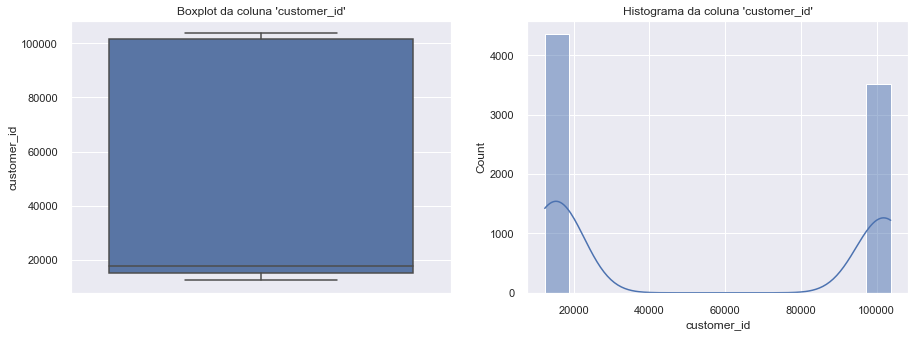

<Figure size 1080x360 with 0 Axes>

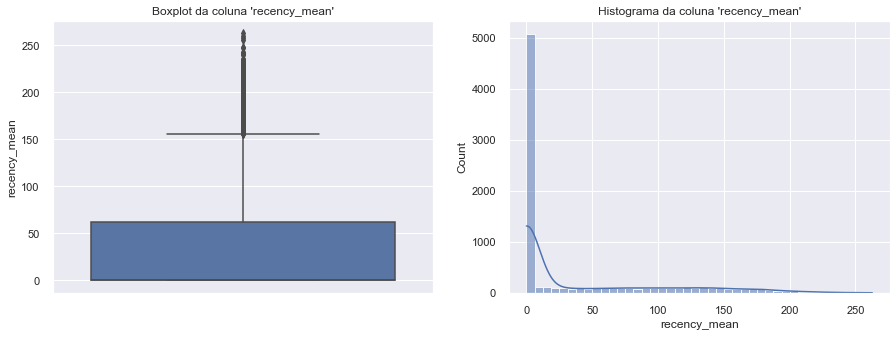

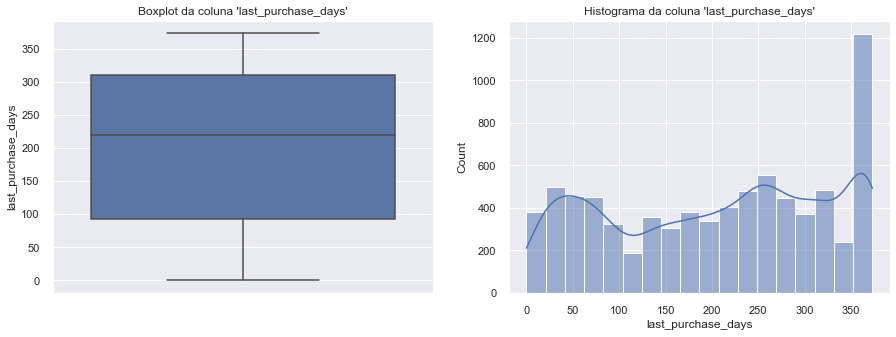

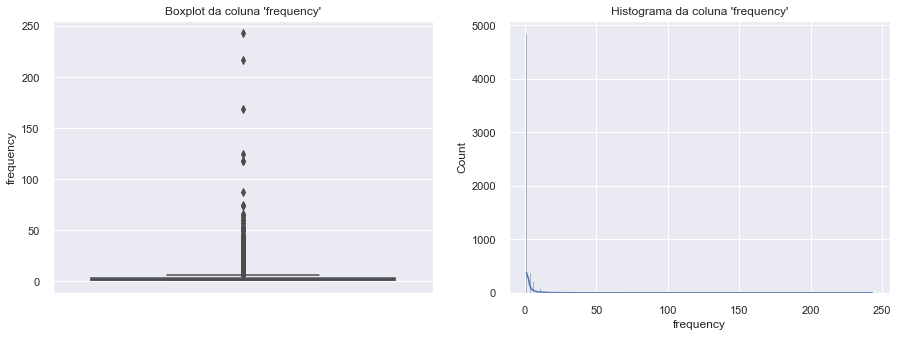

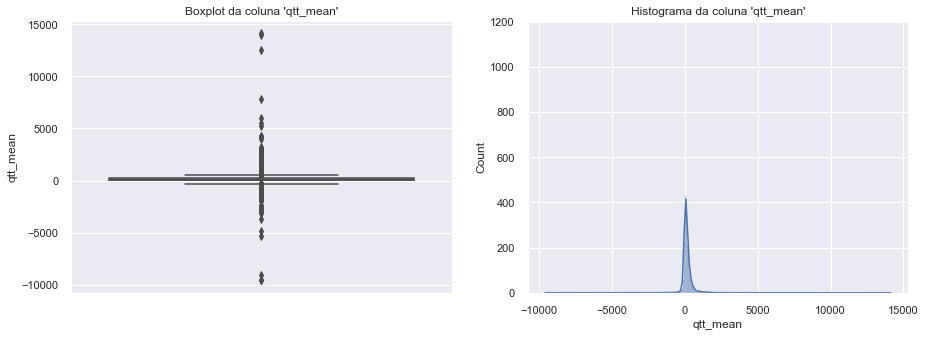

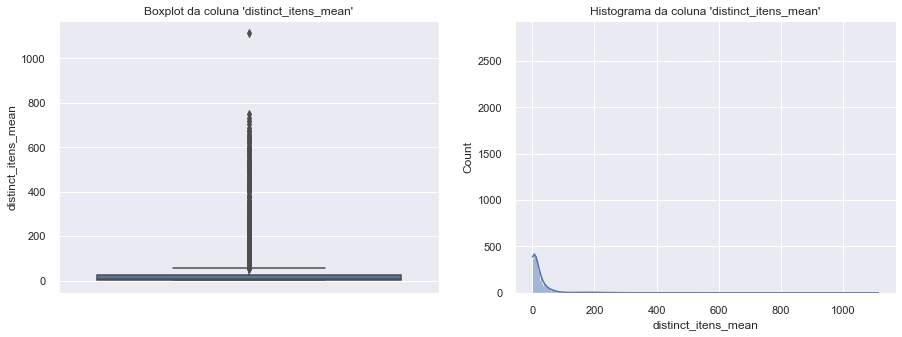

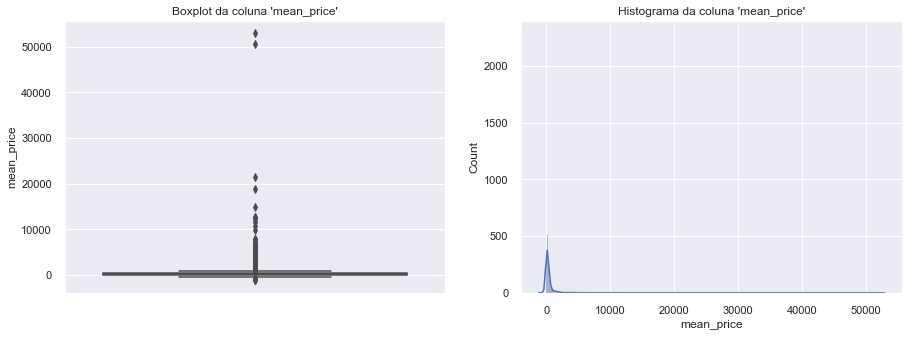

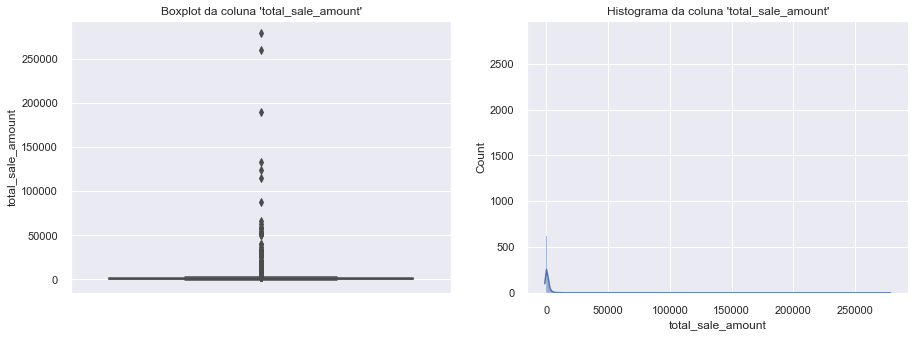

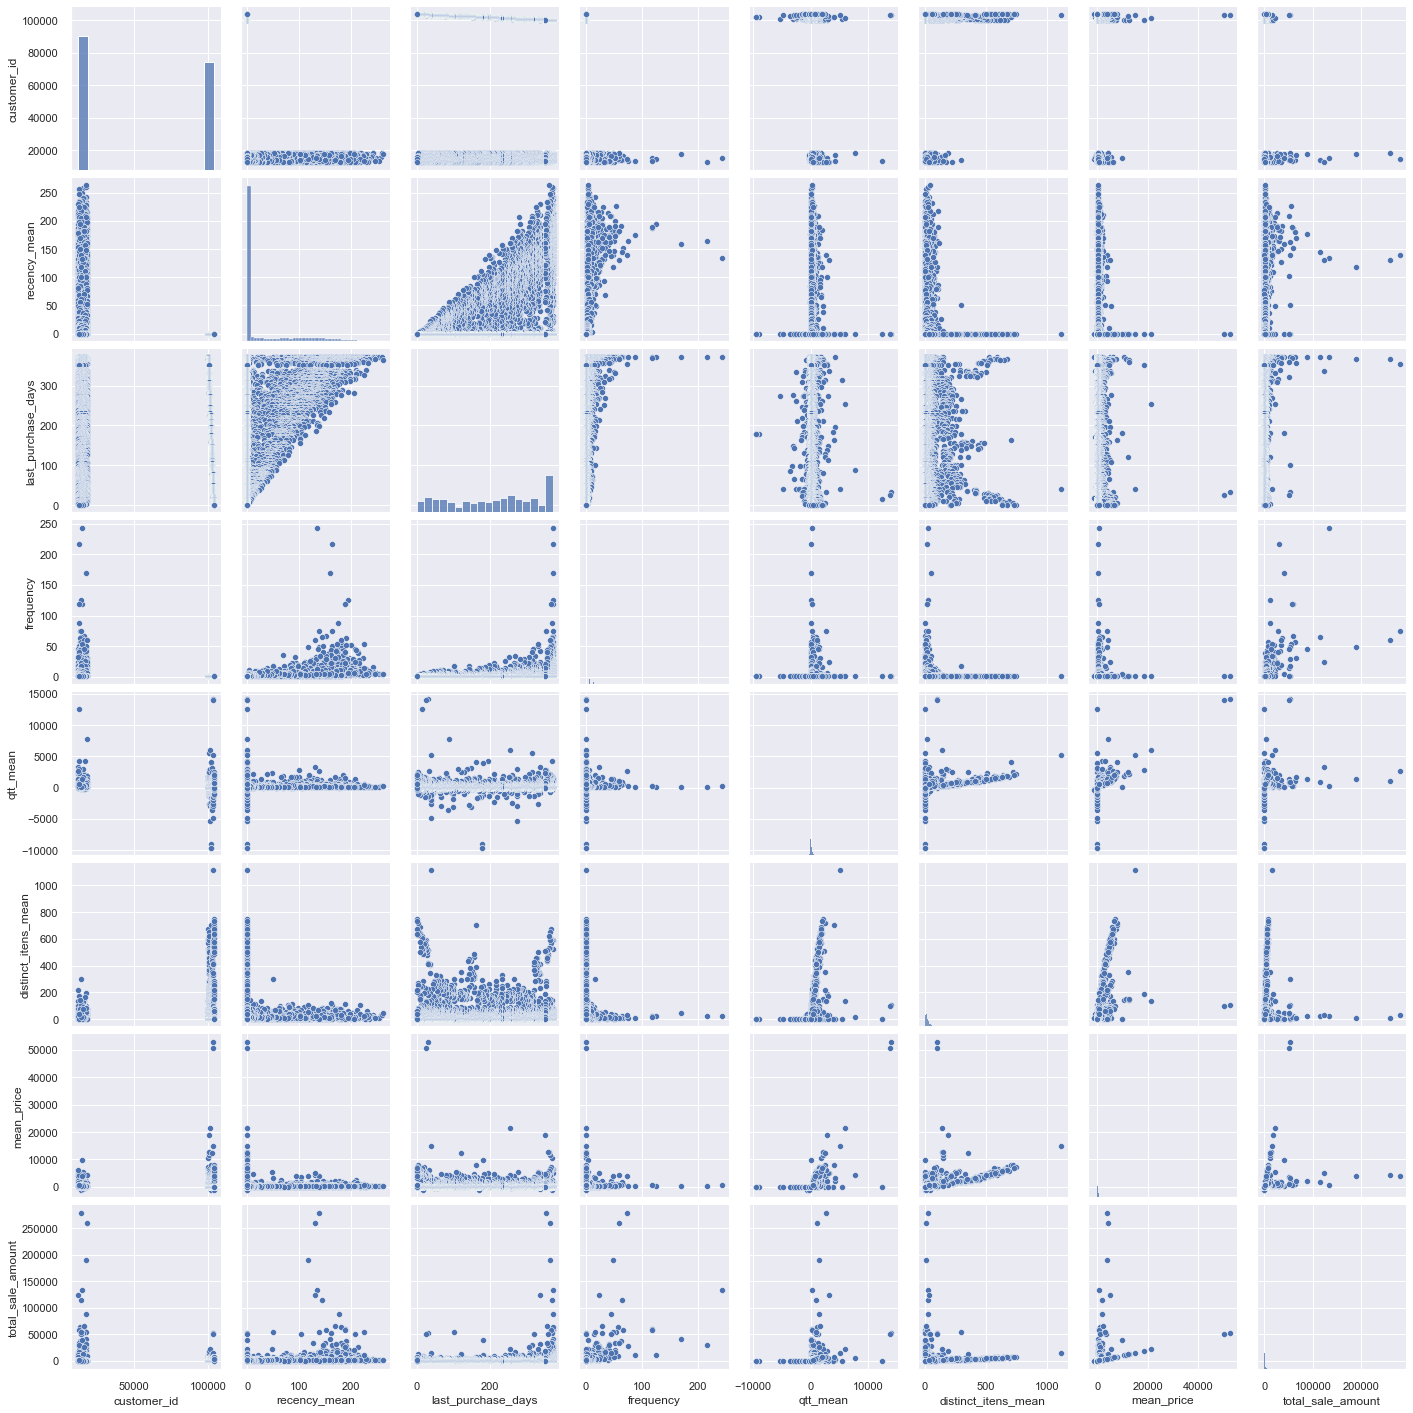

In [98]:
exploratori(df4)

# 5. Data Preparation

In [248]:
df5 = df4.copy()

## 5.1 Tranformation

### 5.1.1 Encoding

In [249]:
le = LabelEncoder()
df5['country'] = le.fit_transform(df5['country'])

# 6. Feature Selection

In [250]:
df6 = df5.copy()

In [251]:
train = df6.drop(columns='customer_id')

# 7. Machine Learning Modeling

In [252]:
clusters = [2, 3, 4, 5, 6, 7]

D:\Users\gtvmi\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
D:\Users\gtvmi\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
D:\Users\gtvmi\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
D:\Users\gtvmi\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
D:\Users\gtvmi\anaconda3\lib\site-packages\sklearn\clust

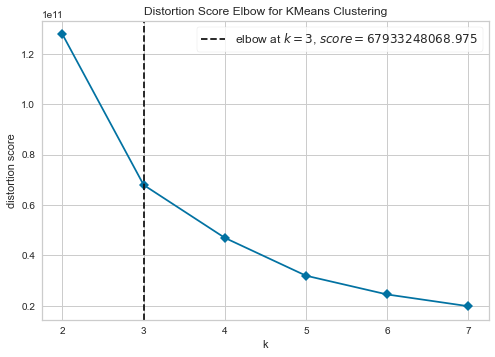

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [253]:
Elbow_M = KElbowVisualizer(KMeans(), k=clusters, timings=False)
Elbow_M.fit(train)
Elbow_M.show()

D:\Users\gtvmi\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
D:\Users\gtvmi\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
D:\Users\gtvmi\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
D:\Users\gtvmi\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
D:\Users\gtvmi\anaconda3\lib\site-packages\sklearn\clust

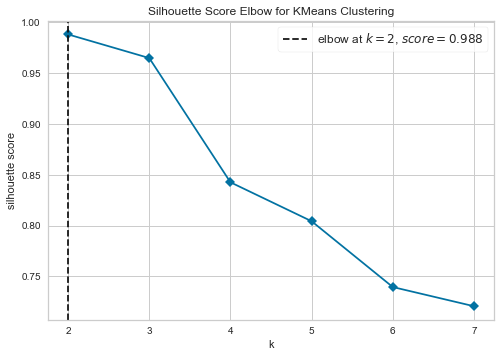

In [254]:
Elbow_M = KElbowVisualizer(KMeans(), k=clusters, timings=False, metric='silhouette');
Elbow_M.fit(train);
Elbow_M.show();

## 7.1 Silhouette Analysis

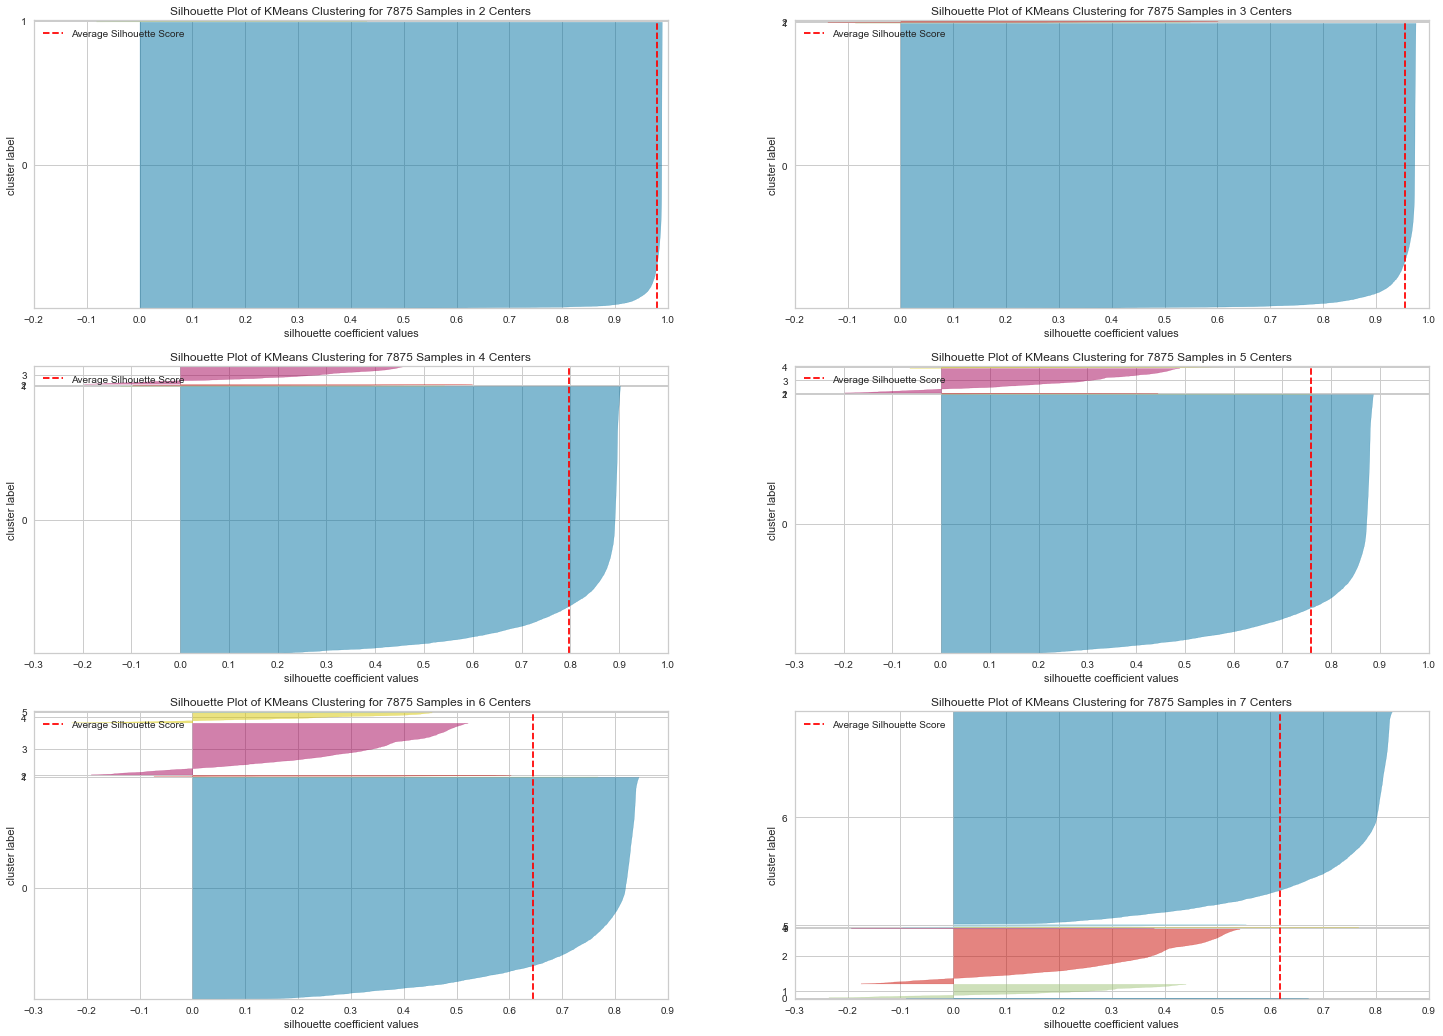

In [255]:
fig, ax = plt.subplots(3, 2, figsize = (25, 18))
for k in clusters:
    km = KMeans(n_clusters=k,
                init='random',
                n_init=10,
                max_iter=100,
                random_state=42)
    q, mod = divmod(k, 2)
    visualizer = SilhouetteVisualizer(km, colors='yellowbrick', ax=ax[q-1][mod])
    visualizer.fit(train)
    visualizer.finalize()

# 8. Model Training

In [256]:
# Nº de clusters
k = 4

# Modelo
kmeans = KMeans(n_clusters=4,
                init='random',
                n_init=10,
                max_iter=100,
                random_state=42)

# Treinamento do Modelo
kmeans.fit(train)

# Clusters
labels = kmeans.labels_

In [257]:
# WCSS
print('WCSS value: {}'.format(kmeans.inertia_))

# SS
print('SS value: {}'.format(mt.silhouette_score(train, labels, metric='euclidean')))

WCSS value: 54347898943.9502
SS value: 0.7972812150422395


# 9. Cluster Analisys

In [198]:
df9 = df6.copy()
df9['label'] = labels
df9.head()

customer_id  invoice_no  itens_qtt  total_qtt  total_invoice_price  \
0        14644      569239         18        192               643.26   
1        18059      569240          5         80               114.96   
2        14488      569241         44        775              1034.28   
3        14193      569242         17        171               400.85   
4        13344      569243         33        250               531.49   

  invoice_date  country  invoice_day  invoice_month  invoice_year  label  
0   2017-10-01       26            1             10          2017      2  
1   2017-10-01       26            1             10          2017      2  
2   2017-10-01       26            1             10          2017      0  
3   2017-10-01       26            1             10          2017      2  
4   2017-10-01       26            1             10          2017      2

## 9.1 Visualization Inspection

D:\Users\gtvmi\anaconda3\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(


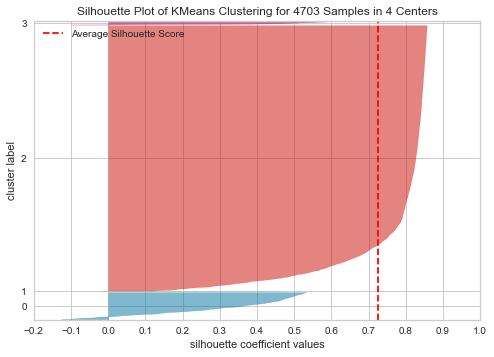

In [199]:
visualizer = SilhouetteVisualizer(kmeans, colors='yellowbrick')
visualizer.fit(train)
visualizer.finalize()

## 9.2 2D Plod

In [200]:
df9.head()

customer_id  invoice_no  itens_qtt  total_qtt  total_invoice_price  \
0        14644      569239         18        192               643.26   
1        18059      569240          5         80               114.96   
2        14488      569241         44        775              1034.28   
3        14193      569242         17        171               400.85   
4        13344      569243         33        250               531.49   

  invoice_date  country  invoice_day  invoice_month  invoice_year  label  
0   2017-10-01       26            1             10          2017      2  
1   2017-10-01       26            1             10          2017      2  
2   2017-10-01       26            1             10          2017      0  
3   2017-10-01       26            1             10          2017      2  
4   2017-10-01       26            1             10          2017      2

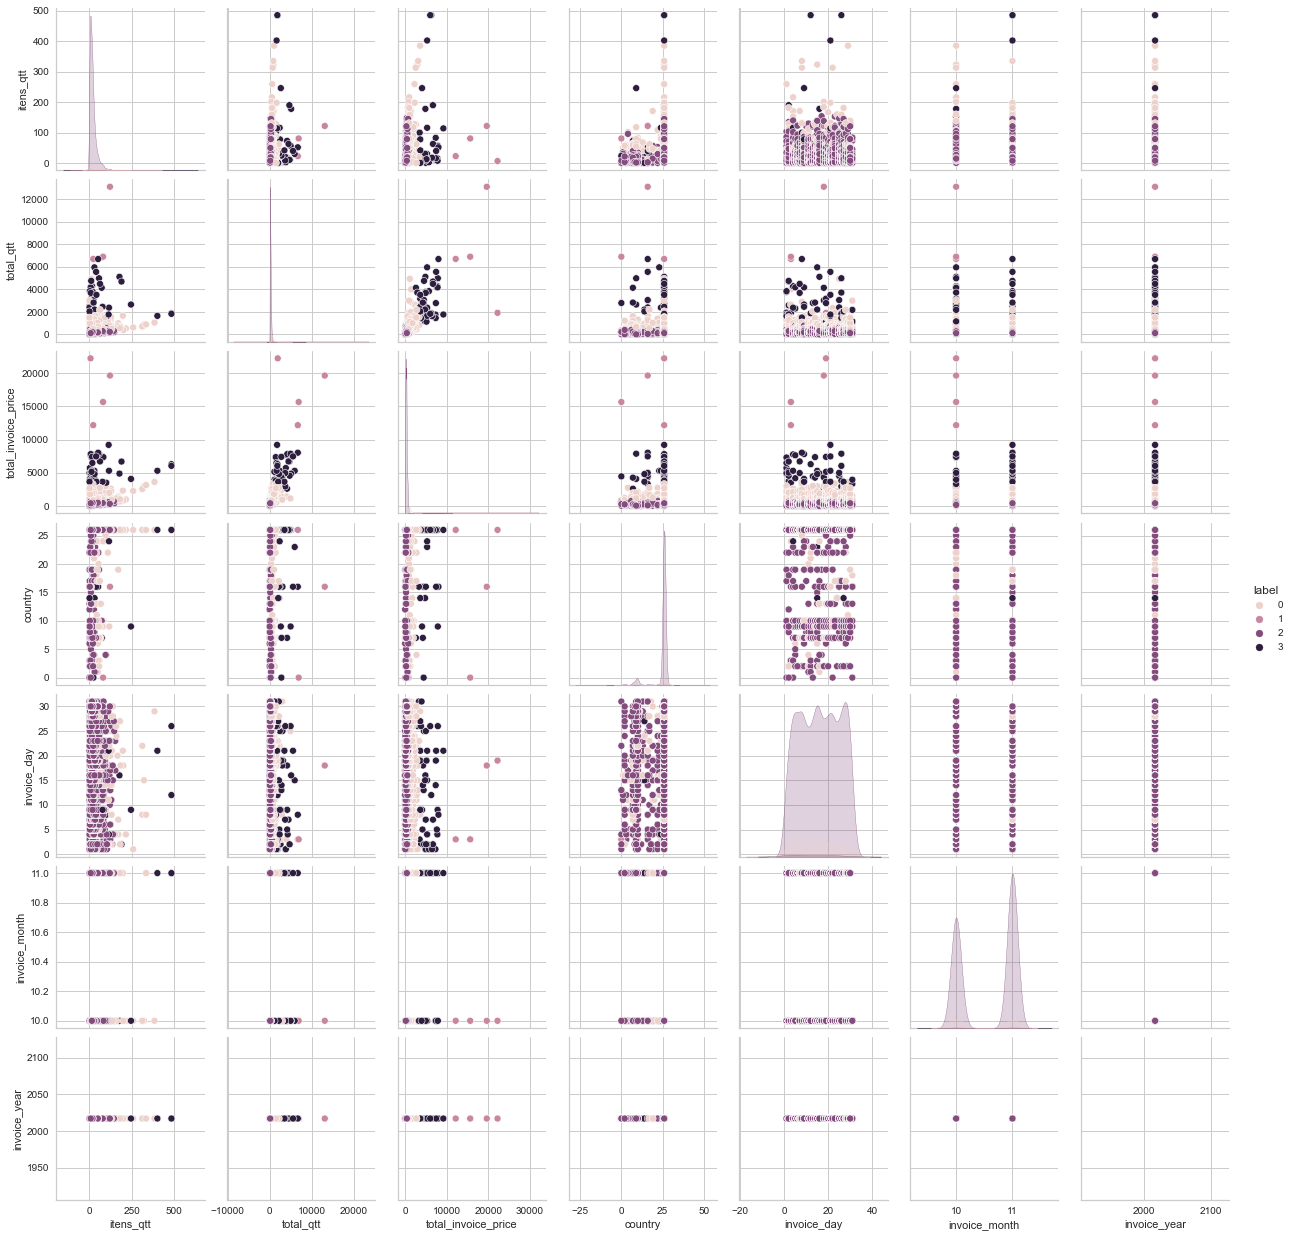

In [205]:
df_viz = df9.drop(columns=['customer_id', 'invoice_no'])
sns.pairplot(data=df_viz, hue='label')

## 9.3 UMAP

<AxesSubplot:xlabel='embedding_x', ylabel='embedding_y'>

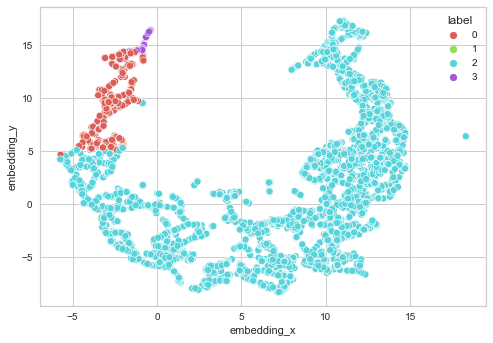

In [215]:
reducer = umap.UMAP( random_state=42, n_neighbors=5 )
embedding = reducer.fit_transform(train)

# embedding
df_viz['embedding_x'] = embedding[:, 0]
df_viz['embedding_y'] = embedding[:, 1]

# Plot UMAP
sns.scatterplot(data=df_viz,
                x = 'embedding_x',
                y = 'embedding_y',
                hue = 'label',
                palette = sns.color_palette('hls', n_colors=len(df_viz['label'].unique())))